<a href="https://colab.research.google.com/github/AEE099/med-specialty-classifier/blob/main/06_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  classification_report
from sklearn.model_selection import cross_validate


In [ ]:
#Cargar datos
df= pd.read_csv("consultas.csv", encoding='latin1')

#Separa variables independiente y dependiente.



x= df.drop(columns=["Especialidad"])
y= df['Especialidad']
# Agrupar clases raras
frecuencia = y.value_counts()
clases_raras = frecuencia[frecuencia < 10].index
y = y.replace(clases_raras, "Otra")
#Columna numericas  y categoricas

num_cols=["ANO"]
cat_cols= ["Edad", "MES", "Sexo", ]


#Dividir training/ test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Preprosamiento

prepprocesamiento=ColumnTransformer(transformers=[("num", Pipeline([("imputer", SimpleImputer(strategy="mean")),
                                                                   ("scaler", StandardScaler())

]),num_cols),
                                                  ("cat", Pipeline ([
                                                      ("imputer", SimpleImputer(strategy="most_frequent")),
                                                      ("encoder", OneHotEncoder(handle_unknown="ignore"))
                                                  ]), cat_cols)
                                                    ])

In [ ]:
frecuencia = y.value_counts()
print(frecuencia)
#

Especialidad
Ginecologia                                           46485
Medicina Familiar                                     28529
Pediatria                                             21271
Ortopedia                                             17362
Cirugia                                               15904
Medicina Interna                                      14723
Cardiologia                                            9713
Gastroenterologia                                      9262
Urologia                                               8837
Endocrinologia                                         7040
Salud Mental                                           5873
Eval. Pre-Anestesica                                   5459
Neonatologia                                           4386
Hematologia                                            4241
Cirugia Vascular                                       4240
Neurocirugia                                           4200
Geriatria                  

In [ ]:
#Modelos supervisados
modelos={
     "LogisticRegression": LogisticRegression(max_iter=1000),
     "RamdomForest":RandomForestClassifier(),
     "GradientBoosting": GradientBoostingClassifier(),
     "KNN": KNeighborsClassifier()
}

#Evaluacion de los modelos con CV
for nombre, modelo in modelos.items():
  pipeline= Pipeline ([ ("preprocesamiento", prepprocesamiento),
                       ("clasificador", modelo)
  ])


  resultados= cross_validate(pipeline, x_train, y_train,
                             cv=5, scoring=["f1_macro","accuracy", "roc_auc_ovr"],
                             return_train_score= False,
                             n_jobs=1)
  print(f"\n📌 Resultados para {nombre}")
  print(f"F1 macro: {resultados['test_f1_macro'].mean():.3f}")
  print(f"Accuracy: {resultados['test_accuracy'].mean():.3f}")
  print(f"ROC AUC (OVR): {resultados['test_roc_auc_ovr'].mean():.3f}")


📌 Resultados para LogisticRegression
F1 macro: 0.073
Accuracy: 0.353
ROC AUC (OVR): 0.750

📌 Resultados para RamdomForest
F1 macro: 0.083
Accuracy: 0.340
ROC AUC (OVR): 0.633

📌 Resultados para GradientBoosting
F1 macro: 0.072
Accuracy: 0.338
ROC AUC (OVR): 0.733

📌 Resultados para KNN
F1 macro: 0.081
Accuracy: 0.279
ROC AUC (OVR): 0.567


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Pipeline base (ya definido antes)
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# 🔧 Ajuste fino para RandomForest
rf_pipeline = Pipeline([
    ("preprocesamiento", preprocessor),
    ("clasificador", RandomForestClassifier(random_state=42))
])

rf_params = {
    "clasificador__n_estimators": [100, 200],
    "clasificador__max_depth": [None, 10, 20],
    "clasificador__min_samples_split": [2, 5],
    "clasificador__class_weight": ["balanced"]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
rf_grid.fit(x_train, y_train)

print("\n✅ Mejor configuración para RandomForest:")
print(rf_grid.best_params_)

# 🔧 Ajuste fino para LogisticRegression
lr_pipeline = Pipeline([
    ("preprocesamiento", preprocessor),
    ("clasificador", LogisticRegression(max_iter=1000, random_state=42))
])

lr_params = {
    "clasificador__C": [0.01, 0.1, 1, 10],
    "clasificador__penalty": ["l2"],
    "clasificador__solver": ["saga", "lbfgs"],
    "clasificador__class_weight": ["balanced"]
}

lr_grid = GridSearchCV(
    lr_pipeline,
    lr_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
lr_grid.fit(x_train, y_train)

print("\n✅ Mejor configuración para LogisticRegression:")
print(lr_grid.best_params_)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



✅ Mejor configuración para RandomForest:
{'clasificador__class_weight': 'balanced', 'clasificador__max_depth': None, 'clasificador__min_samples_split': 5, 'clasificador__n_estimators': 200}

✅ Mejor configuración para LogisticRegression:
{'clasificador__C': 1, 'clasificador__class_weight': 'balanced', 'clasificador__penalty': 'l2', 'clasificador__solver': 'lbfgs'}


Evauacion final: RandomForest
                                                    precision    recall  f1-score   support

Cardiologia                                              0.09      0.01      0.02      1926
Cardiologia Pediatrica                                   0.05      0.32      0.08       197
Cirugia                                                  0.15      0.02      0.03      3270
Cirugia Torax                                            0.00      0.00      0.00         8
Cirugia Vascular                                         0.06      0.06      0.06       877
Consulta Odontologica                                    0.00      0.00      0.00         6
Dermatologia                                             0.01      0.06      0.01       272
Diabetologia                                             0.02      0.14      0.03       286
Emergencia Pediatrica                                    0.00      0.00      0.00         2
Endocrinologia                                   

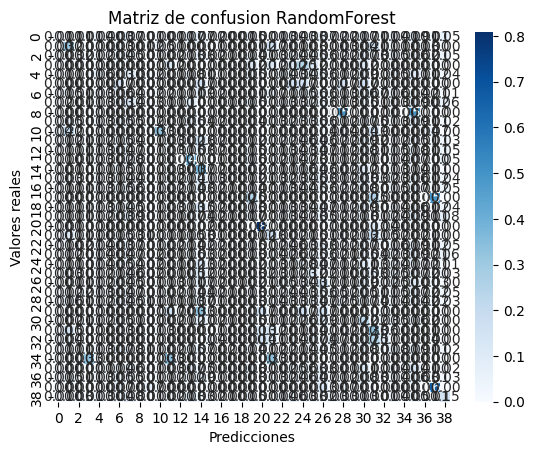

Evauacion final: LogisticRegression


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                    precision    recall  f1-score   support

Cardiologia                                              0.05      0.00      0.01      1926
Cardiologia Pediatrica                                   0.04      0.32      0.08       197
Cirugia                                                  0.13      0.01      0.01      3270
Cirugia Torax                                            0.00      0.25      0.00         8
Cirugia Vascular                                         0.06      0.05      0.05       877
Consulta Odontologica                                    0.00      0.17      0.00         6
Dermatologia                                             0.00      0.00      0.00       272
Diabetologia                                             0.02      0.11      0.04       286
Emergencia Pediatrica                                    0.00      0.00      0.00         2
Endocrinologia                                           0.08      0.00      0.

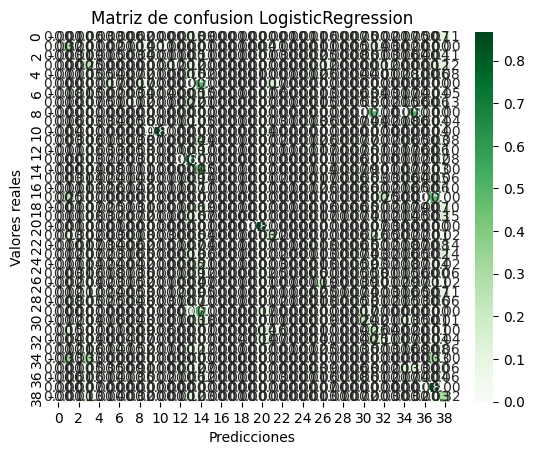

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Modelo final: RandomForest

rf_pipeline_final= Pipeline ([ ("preprocesamiento", preprocessor),
("clasificador", RandomForestClassifier(
    class_weight="balanced",
    max_depth=None,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
))

])

rf_pipeline_final.fit(x_train, y_train)

y_pred_rf= rf_pipeline_final.predict(x_test)

print("Evauacion final: RandomForest")
print(classification_report(y_test, y_pred_rf))


#Matriz de confusion

cm_rf= confusion_matrix(y_test, y_pred_rf , normalize="true")
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap="Blues")
plt.title("Matriz de confusion RandomForest")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()



#Modelo fial: LogisticRegression

lr_pipeline_final= Pipeline([("preprocesamiento", preprocessor),
                             ("clasificador",LogisticRegression(
                                 C=1,
                                 class_weight="balanced",
                                 penalty="l2",
                                 solver="lbfgs",
                                 max_iter=1000,
                                 random_state=42
                             ))])

lr_pipeline_final.fit(x_train, y_train)
y_pred_lr = lr_pipeline_final.predict(x_test)

print("Evauacion final: LogisticRegression")
print(classification_report(y_test, y_pred_lr))


#Matriz de confusion

cm_lr= confusion_matrix(y_test, y_pred_lr , normalize="true")
sns.heatmap(cm_lr, annot=True, fmt=".2f", cmap="Greens")
plt.title("Matriz de confusion LogisticRegression")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


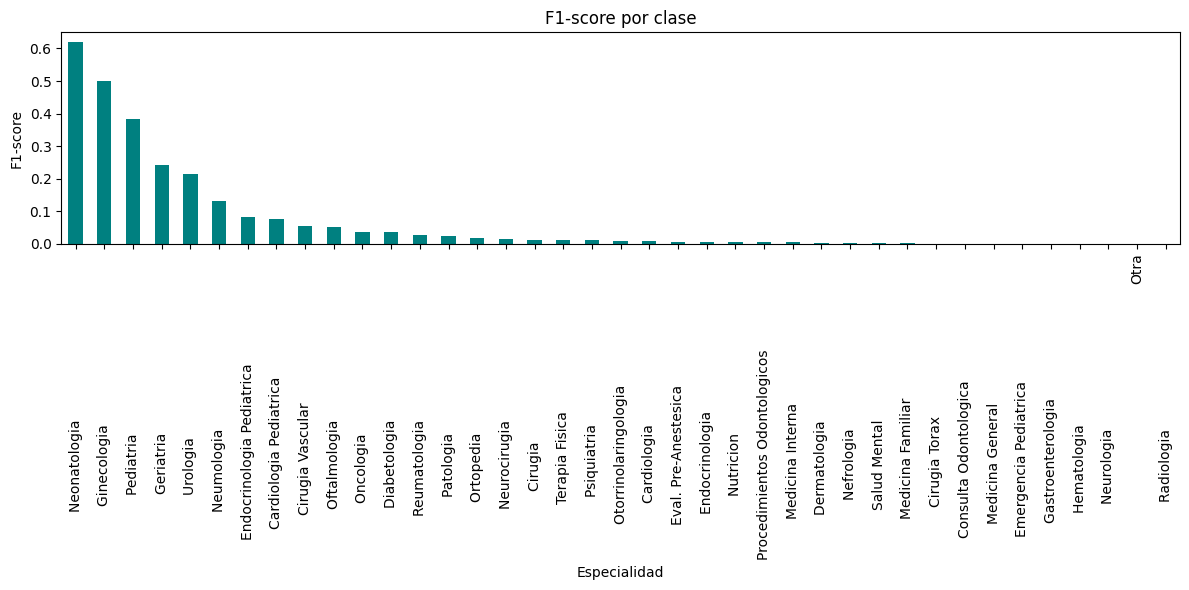

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Obtener el classification report como dict
report_dict = classification_report(y_test, y_pred_lr, output_dict=True)

# Convertir a DataFrame y eliminar promedios globales
df_report = pd.DataFrame(report_dict).transpose()
df_clases = df_report.drop(index=["accuracy", "macro avg", "weighted avg"])

# Graficar F1-score por clase
plt.figure(figsize=(12, 6))
df_clases["f1-score"].sort_values(ascending=False).plot(kind="bar", color="teal")
plt.title("F1-score por clase")
plt.ylabel("F1-score")
plt.xlabel("Especialidad")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



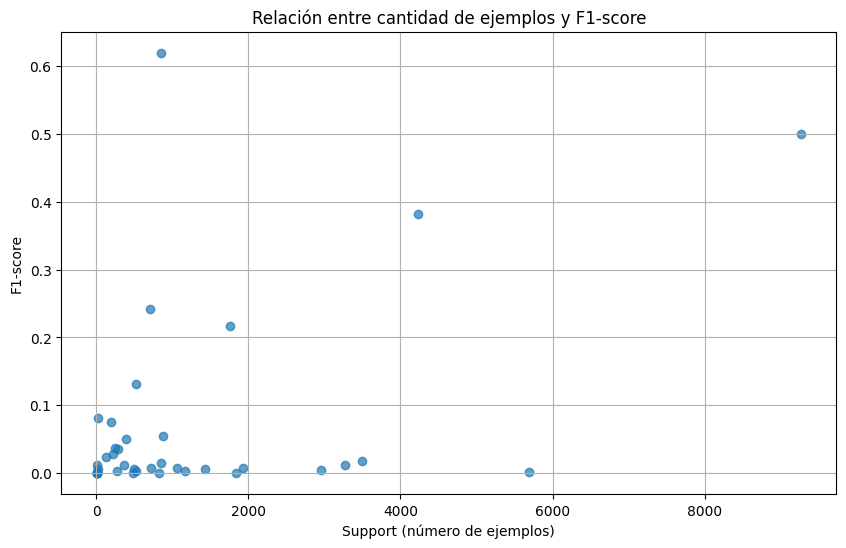

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clases["support"], df_clases["f1-score"], alpha=0.7)
plt.title("Relación entre cantidad de ejemplos y F1-score")
plt.xlabel("Support (número de ejemplos)")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()
